<h1> Transfer Learning - classifying 2 classes of images

In [1]:
#imports
import torch
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from timeit import default_timer as timer


In [73]:
df = pd.read_csv('Train.csv')

paths1 = df[(df['ClassId'] ==1)]['Path'].values
paths2 = df[(df['ClassId'] ==2)]['Path'].values

#keep the images as PIL so they can be transformed later
class1_arrs = []
for path in paths1:
    image = cv2.imread(path)
    image_from_array = Image.fromarray(image, 'RGB')
    class1_arrs.append(image_from_array)
    

class2_arrs = []
for path in paths2:
    image = cv2.imread(path)
    image_from_array = Image.fromarray(image, 'RGB')
    class2_arrs.append(image_from_array)





In [66]:
X = class1_arrs + class2_arrs
y = len(class1_arrs)*[0] + len(class2_arrs)*[1]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =0)

In [68]:
image_transforms = transforms.Compose([transforms.Resize((224,224)), #need tuple
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

<class 'PIL.Image.Image'>


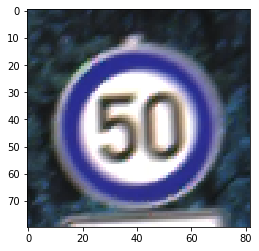

In [69]:
#image before transform
print(type(X_train[0]))
plt.imshow(X_train[0])
plt.show()

In [70]:
for i in range(len(X_train)):
    X_train[i] = image_transforms(X_train[i])

In [71]:
print(X_train[0].shape)
print(X_train[0])

torch.Size([3, 224, 224])
tensor([[[-1.2617, -1.2617, -1.2617,  ..., -1.5528, -1.5528, -1.5528],
         [-1.2617, -1.2617, -1.2617,  ..., -1.5528, -1.5528, -1.5528],
         [-1.3302, -1.3302, -1.3302,  ..., -1.5528, -1.5699, -1.5699],
         ...,
         [-1.4843, -1.4843, -1.5185,  ..., -1.5357, -1.5699, -1.5699],
         [-1.5528, -1.5528, -1.5699,  ..., -1.5014, -1.5699, -1.5699],
         [-1.5528, -1.5528, -1.5699,  ..., -1.5014, -1.5699, -1.5699]],

        [[-0.8277, -0.8277, -0.8102,  ..., -1.2479, -1.2654, -1.2654],
         [-0.8277, -0.8277, -0.8102,  ..., -1.2479, -1.2654, -1.2654],
         [-0.8978, -0.8978, -0.8803,  ..., -1.2479, -1.2829, -1.2829],
         ...,
         [-1.0378, -1.0553, -1.1253,  ..., -0.9853, -1.0728, -1.0903],
         [-1.1078, -1.1253, -1.1954,  ..., -0.9328, -1.0378, -1.0553],
         [-1.1078, -1.1253, -1.1954,  ..., -0.9328, -1.0378, -1.0553]],

        [[-0.2532, -0.2532, -0.2358,  ..., -0.8633, -0.8981, -0.8981],
         [-0.2707, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


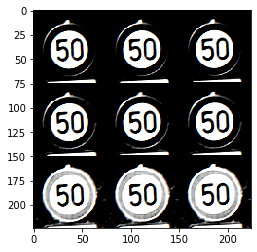

In [72]:
#image after transform
plt.imshow(X_train[0].view(224,224,3))
plt.show()
#why is it like this

In [64]:
#create training and testing sets
train_data = [(X_train[i], y_train[i]) for i in range(len(X_train))]
#test_data = [(X_test[i], y_test[i]) for i in range(len(X_test))]
print(len(train_data))

trainset = torch.utils.data.DataLoader(train_data, batch_size=12, shuffle=True)
#testset = torch.utils.data.DataLoader(test_data, batch_size=36, shuffle=True)

3576


<h2> RESNET34

In [24]:
#print model
res_model = models.resnet34(pretrained=True)
res_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# Freeze early layers
for param in res_model.parameters():
    param.requires_grad = False

In [26]:
inputs = res_model.fc.in_features
print(inputs)

512


In [27]:
#define own fc layer
res_model.fc = nn.Sequential(
        nn.Linear(inputs, 100), nn.ReLU(), nn.Linear(100,2), nn.LogSoftmax(dim=1))

res_model.fc

Sequential(
  (0): Linear(in_features=512, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=2, bias=True)
  (3): LogSoftmax()
)

In [28]:
# Find total parameters and trainable parameters-- code taken from tutorial
total_params = sum(p.numel() for p in res_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in res_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

21,336,174 total parameters.
51,502 training parameters.


In [39]:
#define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_model.parameters(), lr=0.0005)

#make sure we only calculate gradient for the last layers
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([100, 512])
torch.Size([100])
torch.Size([2, 100])
torch.Size([2])


In [44]:
#training the model
def train(model, criterion, optimizer, train_loader, n_epochs=20):
    loss_vals = []
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
        
    for epoch in range(n_epochs):
        start = timer()
        
        for ii, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            
        loss_vals.append(loss)
        print(f'Epoch: {epoch + 1} \t Training Loss: {loss:.3f} \t Time Elapsed in Epoch: {timer()-start:.2f}')
    plt.plot(range(n_epochs), loss_vals)
    plt.show()

Model has been trained for: 0 epochs.

Epoch: 1 	 Training Loss: 0.309 	 Time Elapsed in Epoch: 489.94
Epoch: 2 	 Training Loss: 0.750 	 Time Elapsed in Epoch: 485.29
Epoch: 3 	 Training Loss: 0.237 	 Time Elapsed in Epoch: 477.55
Epoch: 4 	 Training Loss: 0.187 	 Time Elapsed in Epoch: 476.76
Epoch: 5 	 Training Loss: 0.145 	 Time Elapsed in Epoch: 476.18


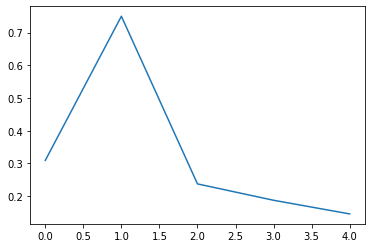

In [45]:
train(res_model, criterion, optimizer, trainset, n_epochs=5)

<h2> VGG16

In [32]:
#print model
vgg_model = models.vgg16(pretrained=True)
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [33]:
# Freeze early layers
for param in vgg_model.parameters():
    param.requires_grad = False

In [34]:
inputs = vgg_model.classifier[0].in_features
print(inputs)

25088


In [35]:
vgg_model.classifier = nn.Sequential(
    nn.Linear(inputs, 100), nn.ReLU(), nn.Linear(100, 64), nn.ReLU(),
    nn.Linear(64,2), nn.LogSoftmax(dim=1))

vgg_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): LogSoftmax()
)

In [36]:
# Find total parameters and trainable parameters-- code taken from tutorial
total_params = sum(p.numel() for p in vgg_model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in vgg_model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

17,230,182 total parameters.
2,515,494 training parameters.


In [37]:
#define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters())

#make sure we only calculate gradient for the last layers
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([100, 25088])
torch.Size([100])
torch.Size([64, 100])
torch.Size([64])
torch.Size([2, 64])
torch.Size([2])


In [38]:
train(vgg_model, criterion, optimizer, trainset, n_epochs=10)

Starting Training from Scratch.

Epoch: 0 	 Training Loss: 0.0008241084287874401 	 Time Elapsed in Epoch: 1568.296845
Epoch: 1 	 Training Loss: 2.5360721338074654e-05 	 Time Elapsed in Epoch: 1596.335848
Epoch: 2 	 Training Loss: 0.0021724344696849585 	 Time Elapsed in Epoch: 1609.298731
Epoch: 3 	 Training Loss: 1.9967487787653226e-06 	 Time Elapsed in Epoch: 1662.987139
Epoch: 4 	 Training Loss: 1.6657946616760455e-05 	 Time Elapsed in Epoch: 1640.789454
Epoch: 5 	 Training Loss: 9.934106870446158e-09 	 Time Elapsed in Epoch: 1316.613305
Epoch: 6 	 Training Loss: 1.9868211964535476e-08 	 Time Elapsed in Epoch: 1394.595352
Epoch: 7 	 Training Loss: 1.400701307829877e-06 	 Time Elapsed in Epoch: 1427.293631
Epoch: 8 	 Training Loss: 2.404030283287284e-06 	 Time Elapsed in Epoch: 1350.341323
Epoch: 9 	 Training Loss: 1.1204934708075598e-05 	 Time Elapsed in Epoch: 1327.780589
